In [24]:
# import libs
from decouple import Config, RepositoryEnv, Csv #https://github.com/HBNetwork/python-decouple/issues/116
import numpy as np
import pymysql
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, Flatten
import tensorflow_model_optimization as tfmot
import keras
from keras.utils import plot_model
import pydot, graphviz
from random import random

In [3]:
config = Config(RepositoryEnv("/Users/Olaf/Documents/GitHub/NonIntrusiveLoadMonitoring/TestModel/.env"))
conn = pymysql.connect(
    host=config('myhost'),
    user=config('myuser'),
    password=config('mypassword'),
    database=config('mydatabase'),
    cursorclass=pymysql.cursors.DictCursor)

In [5]:
cur = conn.cursor()

xx = np.array([])
yy = np.array([])

for key in device_list.keys() :
    # read from mysql db
    #cur.execute("SELECT * FROM data WHERE device = " + str(key) + " LIMIT 10000")
    cur.execute("SELECT * FROM data WHERE device = " + str(key) + " AND timestamp > 1698221020000 LIMIT 10000")
    # get all rows where device is active
    data_list = cur.fetchall()
    # storage for values for current active device
    x = np.array([])

    #size_x = x.size
    active = False
    for row in data_list : 
        if not active : 
            if row['value'] > device_list[key]['minpow'] : 
                active = True
                x = np.append(x, 200 + (random() - 0.5) * abs(100))
                x = np.append(x, row['value'])
        else :
            if row['value'] > device_list[key]['minpow'] :  
                x = np.append(x, row['value'])
            else :
                active = False
                x = np.append(x, 200 + (random() - 0.5) * abs(100))

    # init batch targets for this device
    batch_target_values = np.zeros(len(device_list))
    batch_target_values[int(np.log2(key))] = 1.

    # generate batches with values and targets
    
    i = 0 + window_length
    while i < x.size :
        xx = np.append(xx, x[i - window_length : i])
        yy = np.append(yy, batch_target_values)
        i = i + window_length
    xx = xx.reshape((xx.size // window_length, window_length))
    yy = yy.reshape((yy.size // len(device_list), len(device_list)))

conn.close()

20


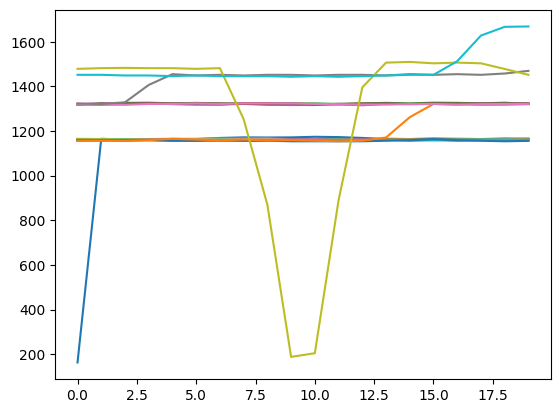

In [6]:
for i in range(xx[0].size) :
    plt.plot(xx[i])
print(xx[0].size)

4


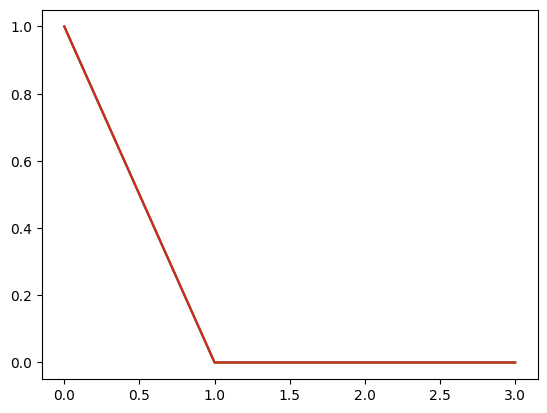

In [7]:
for i in range(yy[0].size) :
    plt.plot(yy[i])
print(yy[0].size)

In [8]:
# input layer
model.add(Input(shape=(window_length)))
model.add(tf.keras.layers.Reshape(target_shape=(window_length, 1)))
# conv1 layer
model.add(tf.keras.layers.Convolution1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# conv2 layer
model.add(tf.keras.layers.Convolution1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# conv3 layer
model.add(tf.keras.layers.Convolution1D(filters=64, kernel_size=3, padding="same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())
# gap
model.add(tf.keras.layers.GlobalAveragePooling1D())
# output layer
model.add(tf.keras.layers.Dense(len(device_list), activation="softmax"))

In [9]:
# TensorBoard 2.15.1 at http://localhost:6006/
#keras.callbacks.TensorBoard(
#    log_dir="/Users/Olaf/Documents/GitHub/NonIntrusiveLoadMonitoring/TestModel/log",
#    histogram_freq=0,  # How often to log histogram visualizations
#    embeddings_freq=0,  # How often to log embedding visualizations
#    update_freq="epoch",
#)  # How often to write logs (default: once per epoch)

In [10]:
# Kompilieren des Modells
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'msle', 'mae'])
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['mse', 'msle', 'mae'])
# Anzeigen der Modellzusammenfassung
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 20, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 batch_normalization (Batch  (None, 20, 64)            256       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 20, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 64)            12352     
                                                                 
 batch_normalization_1 (Bat  (None, 20, 64)            256       
 chNormalization)                                       

In [11]:
# feature generator
def generate_feature(base, peak, width=6, amount=1, rnd=0, size=10) :
    a = np.array([])
    for t in range(amount) :
        a = np.append(a, [base + (random() - 0.5) * abs(rnd) for i in np.arange(1)])
        a = np.append(a, [peak + (random() - 0.5) * abs(rnd) for i in np.arange(size // amount - 2)])
        a = np.append(a, [base + (random() - 0.5) * abs(rnd) for i in np.arange(1)])
    a = np.append(a, [base + (random() - 0.5) * abs(rnd) for i in np.arange(size % amount)]) # correction for uneven num_features
    return a

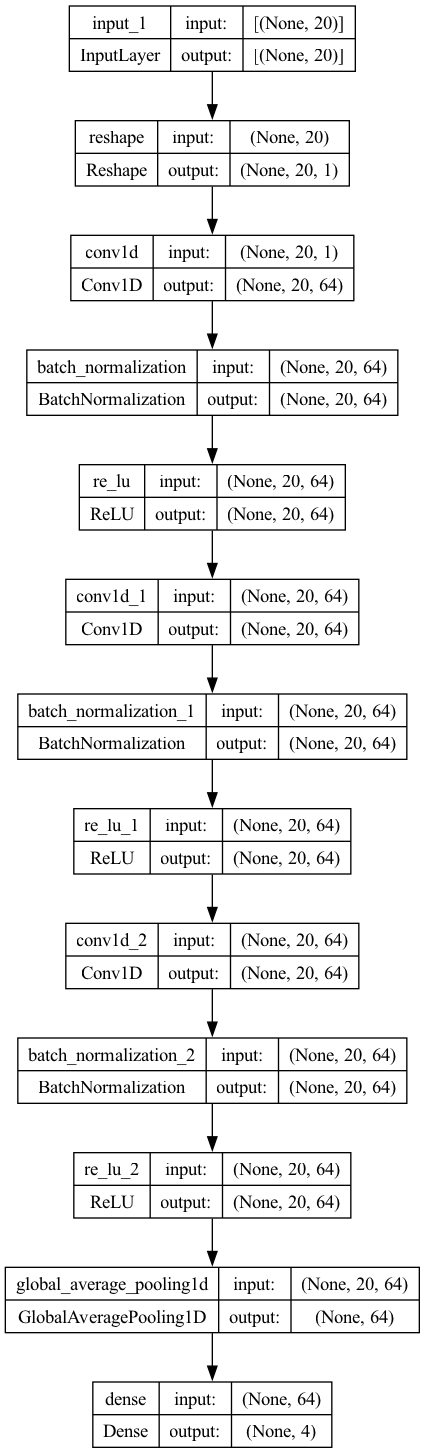

In [12]:
keras.utils.plot_model(model, "my_new_nilm_model.png", show_shapes=True)

In [13]:
# train the model
history = model.fit(
            x=xx,
            y=yy,
            batch_size=xx[0].size,
            epochs=epochs,
            verbose=0)

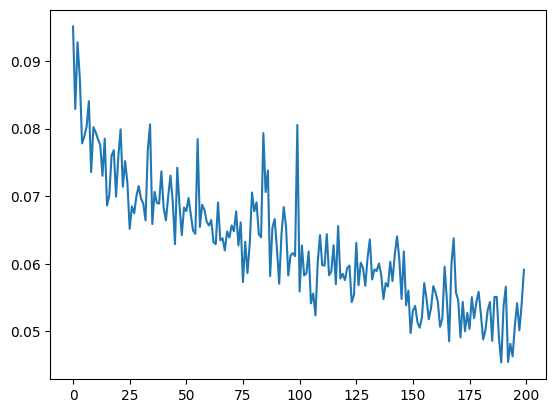

In [14]:
plt.plot(history.history['loss'])

In [15]:
model.save("my_new_nilm_model.keras")

26/26 [==============================] - 0s 1ms/step


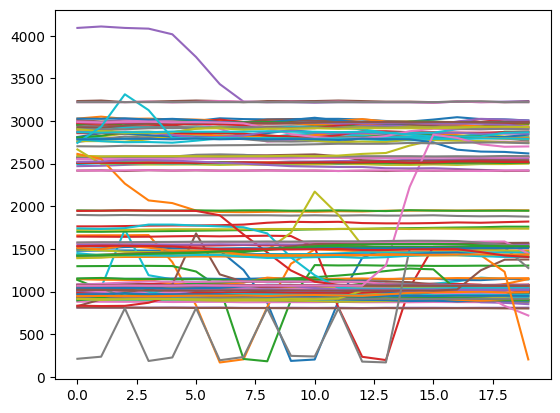

In [22]:
predict_y = model.predict(xx)
    
cnt_wrong = 0
cnt_correct = 0

for i in range(xx.shape[0]) :
    predicted_pos = np.argmax(predict_y[i])
    trained_pos =  np.argmax(yy[i])
    if predicted_pos != trained_pos :
        cnt_wrong = cnt_wrong + 1
        #print("predicted: ", predict_y[i], " and trained: ", yy[i])
        plt.plot(xx[i])
    else :
        cnt_correct = cnt_correct + 1

In [ ]:
print("predictions... ")
print(" total:   ", cnt_wrong + cnt_correct)
print(" correct: ", cnt_correct)
print(" wrong:   ", cnt_wrong)

In [23]:
# loss='mse', metrics=['mse', 'msle', 'mae']
#test1, test2, test3, test4 = model.evaluate(test_x, test_y)